In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12455067702093542274
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11271654605
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2800243769426591478
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
#from preprocess_func_new import *
from matplotlib.image import imread
import os
from os.path import expanduser

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
img_path = os.path.join('..','datasets','stixels')
img_path

'../datasets/stixels'

In [5]:
percent=2 

In [6]:
tfrec_batch_size=1 #for path name only

In [7]:
batch_size=64

In [8]:
tfrec_train_directory = os.path.join('..','datasets','stixels','train','tfrec_batch_size_'+str(tfrec_batch_size)+'_percent_'+str(percent))

In [9]:
#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')



In [10]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:100]
##################

In [11]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 47

In [12]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']

    # The image and label are now correct TensorFlow types.
    return image, label

In [13]:
########## a function to print tensor values
def print_tensor(tensor):
    dataset = tf.data.TFRecordDataset(filenames=[tensor])
    dataset = dataset.map(parse)
    iterator = dataset.make_one_shot_iterator()
    images_batch, labels_batch = iterator.get_next()
    x = {'image': images_batch}
    y = labels_batch
    init_op = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y))
        #print (sess.run(x))
        #return(sess.run(x))
    return

In [15]:
################ try to print the tensors
for t in path_tfrecords_train_lst[:100]:
    #print (t)
    print_tensor(t)
    #print(x)

18
19
26
15
17
29
46
15
16
15
14
33
16
30
25
8
21
20
27
32
22
15
31
19
26
9
36
36
16
15
10
24
30
35
10
18
24
16
17
21
36
22
26
10
29
15
20
14
16
12
23
24
38
32
30
23
31
14
16
15
17
17
22
33
12
17
30
13
20
11
35
17
34
11
28
10
15
18
14
46
46
25
16
11
15
16
21
18
33
28
26
11
46
35
24
13
15
10
20
35


In [106]:
############# print shape of tensor
x2=tf.Session().run(x['image'])
x2.shape


(370, 24, 3)

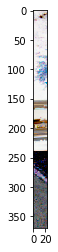

In [107]:
####################. show the parsed stixel
import matplotlib
%matplotlib inline
matplotlib.pyplot.imshow(x2)

In [16]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None #-1
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    
    return x, y

In [17]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [18]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
    #tf.layers.xavier_initializer(
    #uniform=True,
    #seed=481,
    #dtype=tf.float32
    #)
    
    # Reference to the tensor named "image" in the input-function.
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    net = tf.reshape(x, [-1,W,H,C])
    # First convolutional layer.
    net = tf.layers.conv2d(inputs=net, name='layer_conv1',
                           filters=32, kernel_size=(11,5),
                           padding='same', activation=tf.nn.leaky_relu, 
                           kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                           )
    net = tf.layers.max_pooling2d(inputs=net, pool_size=(8,4), strides=1)
    #net = tf.nn.lrn(input=net, depth_radius=4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    # Second convolutional layer.
    #net = tf.layers.conv2d(inputs=net, name='layer_conv2',
     #                      filters=200, kernel_size=(5,3),
      #                     padding='same', activation=tf.nn.leaky_relu,
       #                    kernel_initializer=tf.contrib.layers.xavier_initializer()) #200
    #net = tf.nn.lrn(input=net, depth_radius=4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1')
    #net = tf.layers.max_pooling2d(inputs=net, pool_size=(4,3), strides=1)    

    # Flatten to a 2-rank tensor.
    #net = tf.contrib.layers.flatten(net)
    # Eventually this should be replaced with:
    net = tf.layers.flatten(net)

    # First fully-connected / dense layer.
    # This uses the ReLU activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc1',
                          units=50, activation=tf.nn.leaky_relu,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          )    
    
    net = tf.layers.dropout(inputs=net,rate=0.5, seed=481, 
                          training=(mode=='TRAIN'), name='layer_dropout1'
                           )
    
    # Second fully-connected / dense layer
    #net = tf.layers.dense(inputs=net, name='layer_fc2',
    #                      units=512, activation=tf.nn.relu,
    #                      kernel_initializer=tf.contrib.layers.xavier_initializer()
    #                      )   #2048
    
   
    # This is the last layer so it does not use an activation function.
    net = tf.layers.dense(inputs=net, name='layer_fc3',
                          units=47,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 

    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred)# _cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
 #######################
        lr = 1e-5
        step_rate = 1000
        decay = 0.5 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        
        # Define the optimizer for improving the neural network.
        #optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        
        
#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)
        
    return spec

In [19]:
params = {} #{"learning_rate": 1e-5}

In [20]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [21]:
model_dir = './ckpts_22_5_1conv_1dense_100examples' #'./ckpts_<day>_<month>_<architecture>_<main_change>'
make_dir_and_comment(model_dir) 
model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir,
                               save_checkpoints_steps=1000)

Please add a comment

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './ckpts_22_5_1conv_1dense_100examples', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fbe767c1358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [22]:
model.train(input_fn=train_input_fn, steps=20000)

(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./ckpts_22_5_1conv_1dense_100examples/model.ckpt.
INFO:tensorflow:loss = 86.0047, step = 0
INFO:tensorflow:global_step/sec: 8.69826
INFO:tensorflow:loss = 0.11544885, step = 100 (11.498 sec)
INFO:tensorflow:global_step/sec: 9.03585
INFO:tensorflow:loss = 0.034034945, step = 200 (11.068 sec)
INFO:tensorflow:global_step/sec: 9.03812
INFO:tensorflow:loss = 0.02030489, step = 300 (11.064 sec)
INFO:tensorflow:global_step/sec: 9.09459
INFO:tensorflow:loss = 0.014721774, step = 400 (10.996 sec)
INFO:tensorflow:global_step/sec: 9.07207
INFO:tensorflow:loss = 0.011622226, step = 500 (11.022 sec)
INFO:tensorflo

INFO:tensorflow:loss = 0.0025299063, step = 7500 (11.403 sec)
INFO:tensorflow:global_step/sec: 8.7405
INFO:tensorflow:loss = 0.0025297175, step = 7600 (11.441 sec)
INFO:tensorflow:global_step/sec: 8.73727
INFO:tensorflow:loss = 0.0025295196, step = 7700 (11.445 sec)
INFO:tensorflow:global_step/sec: 8.71459
INFO:tensorflow:loss = 0.002529327, step = 7800 (11.476 sec)
INFO:tensorflow:global_step/sec: 8.72746
INFO:tensorflow:loss = 0.0025291438, step = 7900 (11.458 sec)
INFO:tensorflow:global_step/sec: 8.79627
INFO:tensorflow:loss = 0.0025289385, step = 8000 (11.368 sec)
INFO:tensorflow:global_step/sec: 8.72776
INFO:tensorflow:loss = 0.002528896, step = 8100 (11.458 sec)
INFO:tensorflow:global_step/sec: 8.74167
INFO:tensorflow:loss = 0.0025288537, step = 8200 (11.439 sec)
INFO:tensorflow:global_step/sec: 8.76017
INFO:tensorflow:loss = 0.0025288071, step = 8300 (11.415 sec)
INFO:tensorflow:global_step/sec: 8.75271
INFO:tensorflow:loss = 0.0025287555, step = 8400 (11.424 sec)
INFO:tensorflo

INFO:tensorflow:global_step/sec: 8.7917
INFO:tensorflow:loss = 0.0025283278, step = 15400 (11.375 sec)
INFO:tensorflow:global_step/sec: 8.78154
INFO:tensorflow:loss = 0.0025283278, step = 15500 (11.387 sec)
INFO:tensorflow:global_step/sec: 8.77518
INFO:tensorflow:loss = 0.0025283278, step = 15600 (11.395 sec)
INFO:tensorflow:global_step/sec: 8.75323
INFO:tensorflow:loss = 0.0025283278, step = 15700 (11.424 sec)
INFO:tensorflow:global_step/sec: 8.75031
INFO:tensorflow:loss = 0.0025283278, step = 15800 (11.430 sec)
INFO:tensorflow:global_step/sec: 8.72162
INFO:tensorflow:loss = 0.0025283278, step = 15900 (11.464 sec)
INFO:tensorflow:Saving checkpoints for 15938 into ./ckpts_22_5_1conv_1dense_100examples/model.ckpt.
INFO:tensorflow:global_step/sec: 8.6251
INFO:tensorflow:loss = 0.0025283278, step = 16000 (11.594 sec)
INFO:tensorflow:global_step/sec: 8.64355
INFO:tensorflow:loss = 0.0025283278, step = 16100 (11.572 sec)
INFO:tensorflow:global_step/sec: 8.7372
INFO:tensorflow:loss = 0.00252

In [115]:
###DONE TRAIN###

In [ ]:
#VAL:

In [30]:
tfrec_val_batch_size=1

In [31]:
tfrec_val_directory = os.path.join('..','datasets','stixels','val','tfrec_batch_size_'+str(tfrec_val_batch_size)+'_percent_'+str(percent))

In [32]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [33]:
def val_input_fn():
    return input_fn(path_tfrecords_val_lst[7000:8500], train=False) 

In [34]:
val_result = model.evaluate(input_fn=val_input_fn) 

(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-25-08:48:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_22_5_1conv_1dense_100examples/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-25-08:48:51
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.04144022, global_step = 20000, loss = 15.089501


In [35]:
val_result

{'accuracy': 0.04144022, 'global_step': 20000, 'loss': 15.089501}

In [36]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 4.14%


In [ ]:
#TEST:

In [104]:
tfrec_test_batch_size=1

In [105]:
tfrec_test_directory = os.path.join('..','datasets','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [106]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [107]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test_lst[1000:3000], train=False)

In [108]:
test_result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-22-07:33:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_15_5_decay_xavier_grad_decsent_example7/model.ckpt-24001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-22-07:34:22
INFO:tensorflow:Saving dict for global step 24001: accuracy = 0.1155, global_step = 24001, loss = 4.1837482


In [109]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 11.55%


In [ ]:
#PRED:

In [38]:
sum_csv_test_path = os.path.join(img_path,'train', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_train_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'train', name+'.png')) #maybe no need to add '.png'


In [39]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images)


In [40]:
##TODO:SHUFFLE!
some_num=100
some_images = load_images(image_paths=image_paths_test[0:0+some_num])
some_images_cls = np.array(labels_test['Label'])

In [41]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [42]:
predictions = model.predict(input_fn=predict_input_fn) 

In [43]:
cls_pred = np.array(list(predictions))
cls_pred 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_22_5_1conv_1dense_4examples/model.ckpt-10649
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([[0.01173844, 0.02670282, 0.00659254, ..., 0.01886446, 0.02820454,
        0.03022418],
       [0.01164605, 0.02677397, 0.00646833, ..., 0.01912687, 0.02771651,
        0.03033716],
       [0.0114068 , 0.02712762, 0.00640529, ..., 0.019169  , 0.02678959,
        0.0310404 ],
       ...,
       [0.01041822, 0.02845204, 0.00574676, ..., 0.0181485 , 0.0275079 ,
        0.03119214],
       [0.01022478, 0.02874675, 0.00587737, ..., 0.01858109, 0.02821582,
        0.0311498 ],
       [0.01039221, 0.02890631, 0.00591503, ..., 0.01886374, 0.02799399,
        0.03109998]], dtype=float32)

In [44]:
cls_pred.shape

(100, 47)

In [45]:
cls_pred

array([[0.01173844, 0.02670282, 0.00659254, ..., 0.01886446, 0.02820454,
        0.03022418],
       [0.01164605, 0.02677397, 0.00646833, ..., 0.01912687, 0.02771651,
        0.03033716],
       [0.0114068 , 0.02712762, 0.00640529, ..., 0.019169  , 0.02678959,
        0.0310404 ],
       ...,
       [0.01041822, 0.02845204, 0.00574676, ..., 0.0181485 , 0.0275079 ,
        0.03119214],
       [0.01022478, 0.02874675, 0.00587737, ..., 0.01858109, 0.02821582,
        0.0311498 ],
       [0.01039221, 0.02890631, 0.00591503, ..., 0.01886374, 0.02799399,
        0.03109998]], dtype=float32)

In [46]:
np.histogram(cls_pred, bins=47)

(array([ 52, 107, 108,  75, 150, 154, 159, 263, 344, 371, 133, 216, 256,
        234, 292, 180,  95, 162, 283, 281, 250,  78,  52,  47,  52,  44,
         54,  37,  31,  17,  19,  13,  16,   9,   7,  12,   2,  14,   6,
          8,   5,   3,   1,   2,   1,   2,   3]),
 array([0.00291326, 0.00426659, 0.00561992, 0.00697324, 0.00832657,
        0.0096799 , 0.01103322, 0.01238655, 0.01373988, 0.0150932 ,
        0.01644653, 0.01779986, 0.01915318, 0.02050651, 0.02185984,
        0.02321316, 0.02456649, 0.02591982, 0.02727314, 0.02862647,
        0.0299798 , 0.03133312, 0.03268645, 0.03403978, 0.0353931 ,
        0.03674643, 0.03809976, 0.03945308, 0.04080641, 0.04215974,
        0.04351306, 0.04486639, 0.04621972, 0.04757304, 0.04892637,
        0.0502797 , 0.05163302, 0.05298635, 0.05433968, 0.055693  ,
        0.05704633, 0.05839966, 0.05975298, 0.06110631, 0.06245964,
        0.06381296, 0.06516629, 0.06651962]))

In [47]:
cls_pred[11]

array([0.01013887, 0.02969489, 0.0061564 , 0.02119487, 0.01757099,
       0.02901325, 0.03026538, 0.02745966, 0.02374774, 0.0297063 ,
       0.02675543, 0.03371446, 0.02226516, 0.01580071, 0.01447017,
       0.03927152, 0.01527348, 0.00865516, 0.04348044, 0.04089904,
       0.02201671, 0.01601022, 0.02277997, 0.01496616, 0.01107511,
       0.01454198, 0.02906439, 0.00800654, 0.01769709, 0.02235518,
       0.0306834 , 0.02337936, 0.01381616, 0.02831054, 0.01072191,
       0.00529775, 0.01853069, 0.01654931, 0.01888733, 0.02299123,
       0.01493914, 0.01928054, 0.01303973, 0.02092779, 0.01887416,
       0.02674274, 0.03298091], dtype=float32)

In [48]:
y_pred_cls = tf.argmax(cls_pred, axis=1) 

In [49]:
y_pred_cls

<tf.Tensor 'ArgMax:0' shape=(100,) dtype=int64>

In [50]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y_pred_cls))

[18 18 18 18 18 18 18 18 18 18 18 18 19 19 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 15 19 19 19 19 18 18 18 18 18
 18 18 18 18 18 18 18 18 19 19 18 18 18 18 18 18 18 18 18 18 18 18 18 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 19 19 19 19 19 18 18 18 18 18 18
 18 18 18 18]
